**url**

https://www.baesystems.com/en/news-releases

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.chrome import ChromeDriverManager
option = webdriver.ChromeOptions()
# option.add_argument('headless')
driver = webdriver.Chrome(ChromeDriverManager().install(),options=option)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [C:\Users\AKSHAY SATPUTE\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [3]:
SITE_NAME='Baesystems'

DOMAIN = "https://www.baesystems.com"

SITE_LINK="https://www.baesystems.com/en/news-releases"

In [4]:
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(text):
    return text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

def get_text(link): 
    g = Goose()
    article_extract = g.extract(url=link)
    article = remove_esc_chars(article_extract.cleaned_text)
    meta_data = remove_esc_chars(article_extract.meta_description)
    whole_data = meta_data+article
    text = whole_data.strip()
    
    if textstat.lexicon_count(text, removepunct=True) < 5:
        try:
            response = requests.get(link)
            text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

            if textstat.lexicon_count(text, removepunct=True) < 5:
                texts = ""
                r = requests.get(link)
                filename = Path('temp.pdf')
                filename.write_bytes(r.content)

                pages = convert_from_path('temp.pdf', 500)
                for x in pages:
                    x.save("temp.jpg")
                    output = reader.readtext("temp.jpg")
                    for o in output:
                        texts += o[1]

                text = remove_esc_chars(texts)
                
                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    soup = parse_webpage_bs(link)
                    if soup!= None:
                        ps = soup.findAll('p')
                        for p in ps:
                            texts+= p.text

                    text = remove_esc_chars(texts)
        except:
            text = ""
    
    return text


In [5]:
article_list = []

#getting main url
page_url = SITE_LINK
driver.get(page_url)

#accepting cookies
try :
    driver.find_element(By.XPATH,'''//*[@id="onetrust-accept-btn-handler"]''').click() 
except :
    pass

#geting pagination number
result_count = driver.find_element(By.XPATH,'''//*[@id="search-results-container"]/div/div/div[2]/span[3]''').text
pagination = round(int(result_count)/14)

#getting the url with pagination 
url = f"https://www.baesystems.com/en/news-releases?siteAjax=Global&searchPageNo={pagination}&searchQuery=*"
driver.get(url)

#geting all the elements 
container = driver.find_elements(By.XPATH,'''//p[@class="searchresult-date typed-hide"]''')

#geting the data
for x in range(1,len(container[:20])+1):
    title = driver.find_element(By.XPATH,f'''//*[@id="search-results-container"]/ul/li[{x}]/div[1]/a/h3''').text
    published_date = driver.find_element(By.XPATH,f'''//*[@id="search-results-container"]/ul/li[{x}]/div[1]/p[3]''').text
    link = driver.find_element(By.XPATH,f'''//*[@id="search-results-container"]/ul/li[{x}]/a''').get_attribute('href')
    thumbnail = driver.find_element(By.XPATH,f'''//*[@id="search-results-container"]/ul/li[{x}]/a/img''').get_attribute('data-src')
    text = get_text(link)
    author = SITE_NAME
    
    article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
    article_list.append(article)
    print(published_date,title)

6 Jun 2022 Airborne anti-jam GPS receiver broadens compatibility with inertial navigation systems
2 Jun 2022 BAE Systems’ Automated Flight Planning Service deployed to the cloud
1 Jun 2022 BAE Systems to provide more than 500 electric drive systems for Ontario bus fleets
20 May 2022 New CV90 Combat Support Vehicles delivered to Norway
10 May 2022 Major upgrade to Compass Call with open system architecture
9 May 2022 BAE Systems to bring next-generation electric drive system to heavy-duty industrial vehicle market
9 May 2022 Over £2 billion for next phase of Dreadnought submarine build
5 May 2022 BAE Systems to develop autonomous network technology for multi-domain military missions
4 May 2022 BAE Systems launches new lightweight Head-Up Display – LiteWave®
2 May 2022 BAE Systems opens its new Manchester, N.H. facility, expanding job opportunities and production capabilities
27 Apr 2022 BAE Systems to develop new techniques to overwhelm military adversaries
26 Apr 2022 BAE Systems to co

In [6]:
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,6 Jun 2022,Airborne anti-jam GPS receiver broadens compat...,BAE Systems expanded the capabilities of its D...,https://www.baesystems.com/en/article/airborne...,https://www.baesystems.com/en-media/webImage/2...,Baesystems
1,2 Jun 2022,BAE Systems’ Automated Flight Planning Service...,BAE Systems’ Mobility Air Forces Automated Fli...,https://www.baesystems.com/en/article/bae-syst...,https://www.baesystems.com/en-media/webImage/2...,Baesystems
2,1 Jun 2022,BAE Systems to provide more than 500 electric ...,BAE Systems selected by Toronto Transit Commis...,https://www.baesystems.com/en/article/bae-syst...,https://www.baesystems.com/en-media/webImage/2...,Baesystems
3,20 May 2022,New CV90 Combat Support Vehicles delivered to ...,The first four CV90 Combat Support Vehicles we...,https://www.baesystems.com/en/article/new-cv90...,https://www.baesystems.com/en-media/webImage/2...,Baesystems
4,10 May 2022,Major upgrade to Compass Call with open system...,BAE Systems successfully tests third party sof...,https://www.baesystems.com/en/article/major-up...,https://www.baesystems.com/en-media/webImage/2...,Baesystems


2 Jun 2022 BAE Systems’ Automated Flight Planning Service deployed to the cloud

Baesystems https://www.baesystems.com/en/article/bae-systems--automated-flight-planning-service-deployed-to-the-cloud


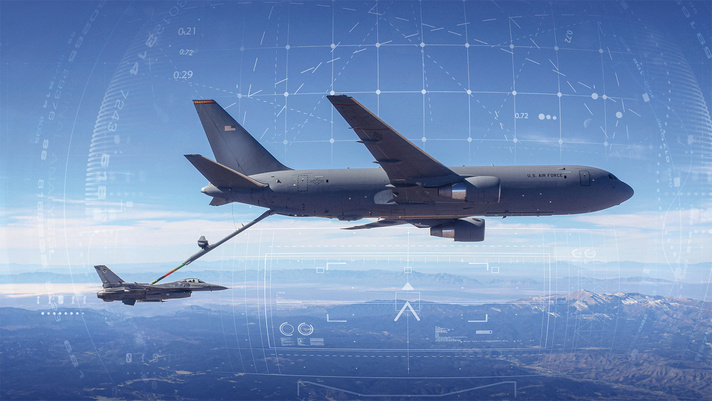


BAE Systems’ Mobility Air Forces Automated Flight Planning Service is transitioning operations to Cloud OneBAE Systems’ Mobility Air Forces Automated Flight Planning Service, or MAFPS, is transitioning operations to Cloud One, one of the first mission-critical applications to complete a cloud migration. BAE Systems is a pioneer for the U.S. Air Force, providing warfighters with improved capabilities for mission management and agile airspace planning.  “The cloud environment will increase the operational availability of MAFPS’ best-in-class services for our customers,” said Meg Redlin, director of Mission Systems at BAE Systems. “The system’s automation streamlines flight planning for the future of airspace operations.”  MAFPS operations in Cloud One align with the U.S. Air Force’s transformation objectives, breaking from legacy on-premise environments to a cutting-edge architecture. The new approach to agile deployment at the enterprise level provides increased storage, computing, and

In [7]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    display(Image.open(io.BytesIO(requests.get(temp_df.iloc[iloc_no]['thumbnail']).content)))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [8]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [9]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        os.remove("temp.jpg")
        os.remove("temp.pdf")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

No trash found
